In [1]:
from PreFRBLE.convenience import *
from PreFRBLE.estimate_redshift import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *

In [2]:
scenario = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18/smd'],
    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
}

scenario = {
    'IGM' : ['primordial'],
    'Host': ['JF12/StarDensity_MW'],
    'Local': ['Piro18/wind'], 
}


scenario_IGM = {
    'IGM' : ['primordial'],
}

f_IGMs = np.arange(0.300,0.901, 0.100)


In [25]:
RM = np.abs(FRBs['RM'])
RM = RM[RM>0]
RM.min(), RM.max()

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


(1.5, 220.6)

In [26]:
def GetFRBsMeasures( measure='DM', FRBs=None ):
    if measure == 'DM':
        return FRBs['DM']-FRBs['DM_gal']
    elif measure == 'RM':
        return FRBs['RM']

observed_range = {
    'DM' : (1e1,1e4),
    'RM' : (1e-1,1e3),
    
}
    
    
def LikelihoodObservedMeasure( measure='DM', scenario={}, telescope='Parkes', population='SMD', FRBs=None, Measures=None, use_localized=True, plot=False, plot_FRBs=False, ax=None, label=None, title=None ):
    """ 
    returns likelihood of values of DM observed by telescope for the case of scenario and population
    
    Parameters
    ----------
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
    
    Returns
    -------
    likelihoods : array-like
        1D array with likelihoods of individual DM observed by telescope  
    """

    P_M, M = GetLikelihood_Telescope( measure=measure, telescope=telescope, population=population, **scenario )
        
    if Measures is None:
        ## read observed values of extragalactic DM
        if FRBs is None:
            FRBs = GetFRBcat( telescopes=[telescope] )
        Measures = GetFRBsMeasures( measure=measure, FRBs=FRBs )
    if plot:
        if ax is None:
            fig, ax = plt.subplots()
        if title is None:
            title = "%s with %s" % (population, telescope)
        ax.set_title( title )
        PlotLikelihood( P=P_M, x=M, measure=measure, label=label, ax=ax )
        
        if plot_FRBs:
            P_, x_ = Histogram( data=Measures, bins=10, log=True, density=True, range=observed_range[measure] )#, range=(1e1,1e4) )
            PlotLikelihood( P=P_, x=x_, measure=measure, ax=ax, label="observed", linestyle='-.', color='black' )
#        AllSidesTicks( ax )
    
    ## compute likelihood of observation
    likelihoods = Likelihoods( measurements=Measures, P=P_M, x=M )
    
    ## for FRBs with localized host, use likelihood for DM from that redshift, P(DM|z_host), instead
    if use_localized:
        localized, = np.where( FRBs['host_redshift']>0 )
        for loc in localized:
            z_host = np.round(FRBs[loc]['host_redshift'],1)
            
            P_z, z = GetLikelihood_Redshift( population=population, telescope=telescope )
            P_M, M = GetLikelihood_Full( measure=measure, redshift=z_host, **scenario )
            
            ## likelihood for host redshift in population 
            prior = Likelihoods( measurements=[z_host], P=P_z, x=z ) ##**( 1 - (telescope in ['ASKAP']) )  ## ignore redhift prior for these telescope, since they are not informative for population
            ## multiply by likelihood for DM at host redshift
            likelihoods[loc], = Likelihoods( measurements=[Measures[loc]], P=P_M, x=M ) * prior 

        if plot_FRBs:
            y_Measures = 0.75-0.5*np.random.rand( len(localized) )
            ax.plot( Measures[localized], y_Measures, marker='x', linestyle=' ' )
    return likelihoods


{'IGM': ['primordial_C300'], 'Local': ['Piro18/wind'], 'Host': ['JF12/StarDensity_MW']}


/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:16: RuntimeWarning: invalid value encountered in log10
  h, x = np.histogram( np.log10(data), bins=bins, range=range )
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:20: RuntimeWarning: invalid value encountered in true_divide
  h = h / ( np.sum( h )*np.diff(x) )


{'IGM': ['primordial_C900'], 'Local': ['Piro18/wind'], 'Host': ['JF12/StarDensity_MW']}


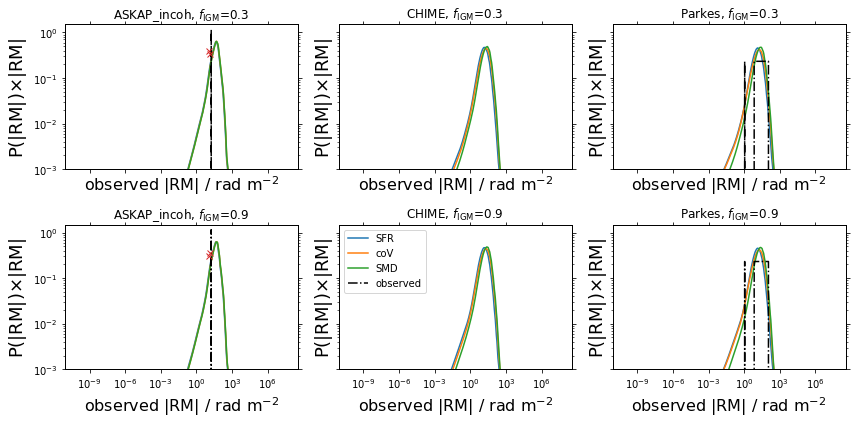

In [43]:
fig, axss = plt.subplots( 2, 3, figsize=(12,6), sharex=True, sharey=True)
for f_IGM, axs in zip( f_IGMs[np.array([0,-1])], axss ):
    tmp = scenario.copy()
    tmp['IGM'] = ['primordial_C%.0f' % (f_IGM*1000)]
    print(tmp)
    for telescope, ax in zip( telescopes, axs):
        ax.set_ylim(1e-3,1.5)
        #ax.set_ylim(1e-5,1.5)
        for population in populations:
            LikelihoodObservedMeasure( measure='RM', scenario=tmp, telescope=telescope, population=population, plot=True, ax=ax, plot_FRBs=population == populations[-1], label=population, title=r"%s, $f_{\rm IGM}$=%.1f" % (telescope, f_IGM) )
        AllSidesTicks(ax)
axss[1][1].legend()
fig.tight_layout()

In [40]:
print(scenario)
with h5.File( likelihood_file_galaxy ) as f:
    print( f['Host/JF12/StarDensity_MW/0.1000'].keys() )

{'IGM': ['primordial'], 'Local': ['Piro18/wind'], 'Host': ['JF12/StarDensity_MW']}
<KeysViewHDF5 ['DM', 'RM']>


/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  
